In [354]:
# !pip install networkx[default]

In [67]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import itertools
from datetime import datetime,timedelta
import time
import networkx

matplotlib.rcParams['font.family']='Malgun Gothic'
pd.set_option('display.max_rows',300)

# 불러오고 전처리

In [68]:
 # 1,2,3월 불러와서 합치기
data = pd.read_csv('data/데이터_SK텔레콤/전북_군산/군산_202101.csv',sep='|')
for i in range(2,4):
    data = pd.concat([data,pd.read_csv(f'data/데이터_SK텔레콤/전북_군산/군산_20210{i}.csv',sep='|')]\
                     ,ignore_index=True)

 # dropna
print(data.shape , data.dropna().shape)
data = data.dropna()

 #  DataFrame에서 '%Y%m%d'  =>  datetime
data.STD_YMD = pd.to_datetime(data.STD_YMD, format='%Y%m%d')

(1212221, 14) (1212221, 14)


In [69]:
data = data.drop('STD_YM',axis=1)
data = data.drop('dst_DO_NAME',axis=1)

In [70]:
data.columns = ['date','day','home_code','home_do','home_gu','dst_gu','dst_dong','dst_code','age','sex','pops','type']
# pop is method!

### 구코드를 도+구로 변경하여 다른 지방자치단체의 같은 구명칭 문제해결

In [71]:
data.home_gu=data.home_do+' '+data.home_gu

### 32개의 겹치는 구이름이 있음

# Functions

In [72]:
# plot column data
def ploteda(i,w=8,h=4):
    x=data.columns[i]
    return data[x].value_counts().sort_index().plot(title=x,figsize=(w,h))

def ploteda_v(i,w=8,h=4):
    x=data.columns[i]
    return data[x].value_counts().sort_values(ascending=False).plot(kind='bar',title=x,figsize=(w,h))
 
# population weighted data
def wdf(i):
    return data.pivot_table(index=data.columns[i],values='pops',aggfunc='sum').rename_axis(index=None)

def wploteda(i,w=8,h=4):
    return wdf(i).sort_index().plot(title=data.columns[i],figsize=(w,h))

def wploteda_v(i,topn=len(wdf(i)),w=8,h=4):
    x=data.columns[i]
    return wdf(i).iloc[:,0].sort_values(ascending=False)[:topn].plot(kind='bar',title=data.columns[i],figsize=(w,h))
                   # make it Series to sort
    
# population weighted data 군산to군산
def wdf_gs(i):
    return data_gs.pivot_table(index=data_gs.columns[i],values='pops',aggfunc='sum').rename_axis(index=None)

def wploteda_gs(i,w=8,h=4):
    return wdf_gs(i).sort_index().plot(title=data_gs.columns[i],figsize=(w,h))

def wploteda_v_gs(i,t=0,w=8,h=4):
    if t==0:
        topn=len(wdf_gs(i))
    else:
        topn=t
    return wdf_gs(i).iloc[:,0].sort_values(ascending=False)[:topn].plot(kind='bar',title=data_gs.columns[i],figsize=(w,h))
                   # make it Series to sort
    


# EDA

## 데이터 분포 탐색 (유동인구로 가중치주지 않음)

### 플롯들이 균일하지 않음 => 유동인구=0인 rows 삭제된 것으로 추정

<AxesSubplot:title={'center':'date'}>

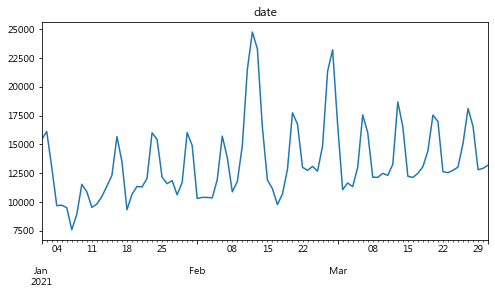

In [189]:
ploteda(0)

<AxesSubplot:title={'center':'day'}>

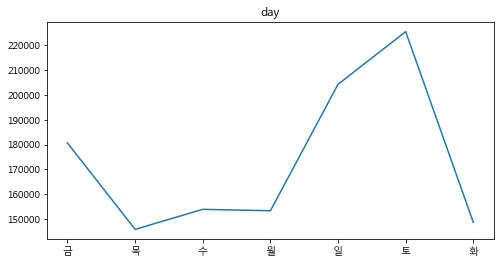

In [190]:
ploteda(1)

<AxesSubplot:title={'center':'home_do'}>

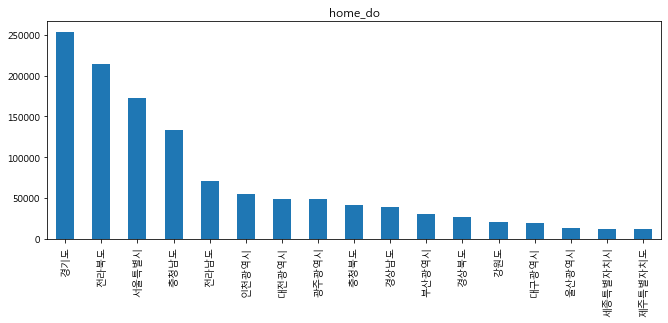

In [191]:
ploteda_v(3,11,4)

<AxesSubplot:title={'center':'home_gu'}>

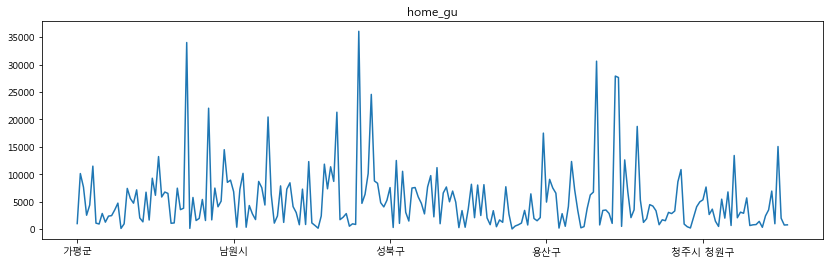

In [192]:
ploteda(4,14,4)

<AxesSubplot:title={'center':'dst_dong'}>

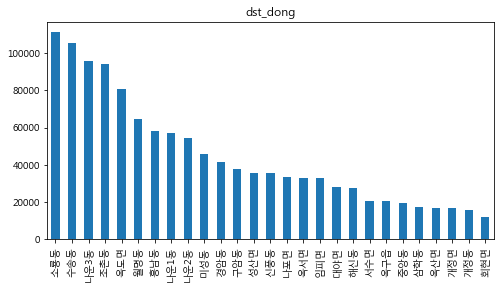

In [193]:
ploteda_v(6)

<AxesSubplot:title={'center':'age'}>

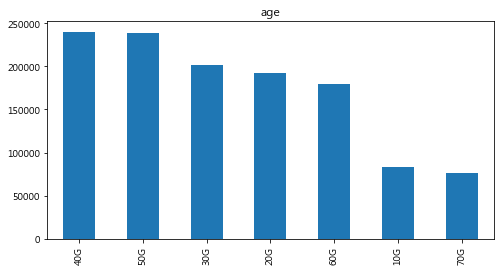

In [194]:
ploteda_v(8)

<AxesSubplot:title={'center':'sex'}>

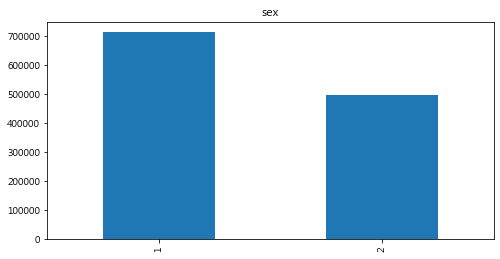

In [195]:
ploteda_v(9)

<AxesSubplot:title={'center':'type'}>

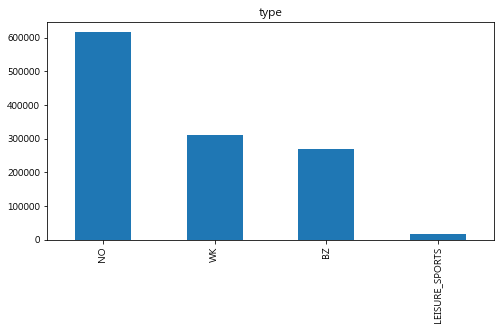

In [202]:
ploteda_v(11)

In [209]:
data[data.iloc[:,11]=='TOUR']

,date,day,home_code,home_do,home_gu,dst_gu,dst_dong,dst_code,age,sex,pops,type


## 표준편차(이상치) 탐색

### 유동인구

In [7]:
data.pops.describe()

count    1.212221e+06
mean     4.134359e+01
std      3.396500e+02
min      1.000000e+00
25%      1.927083e+00
50%      2.941788e+00
75%      5.724986e+00
max      1.222714e+04
Name: pops, dtype: float64

In [8]:
summ = data.pops.sum()
mean = data.pops.mean()
med = data.pops.median()
std = data.pops.std() 
print('sum:', round(summ,2),'  ','mean:', round(mean,2),'  ','med:',round(med,2),'  ','std:', round(std,2))
print(round(mean+std,2),'명 이상인 유동인구가 상위 1표준편차에 해당합니다.')
print('\n')

def data_pops_sig(x):
    print(mean+x*std)
    return data[data.pops >= mean+x*std_fq]
def data_pops_except_sig(x):
    print(mean+x*std)
    return data[data.pops < mean+x*std_fq]

sum: 50117566.64    mean: 41.34    med: 2.94    std: 339.65
380.99 명 이상인 유동인구가 상위 1표준편차에 해당합니다.




In [9]:
data.pops.sum()

50117566.63976868

## 유동인구 가중 EDA

In [145]:
#print(data.pops.sum(),data.pivot_table(index='sex',values='pops',aggfunc='sum').sum()[0]) # for check
#data.pivot_table(index='sex',values='pops',aggfunc='sum')

<AxesSubplot:title={'center':'home_do'}>

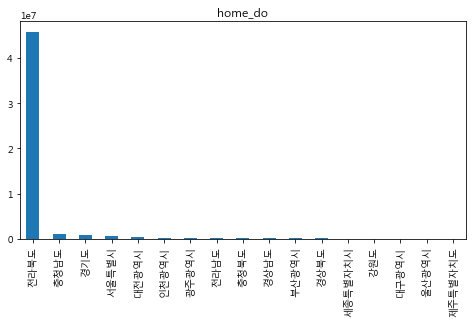

In [223]:
wploteda_v(3)

### 군산시 유입인구가 압도적으로 많아서 전라북도가 많이 잡힌것! (내지인 제외必)

<AxesSubplot:title={'center':'home_gu'}>

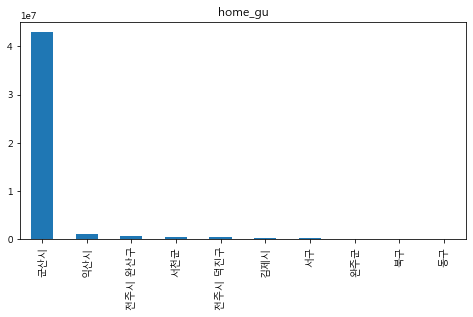

In [224]:
wploteda_v(4,10)

In [226]:
data.home_code.value_counts().shape

(250,)

In [352]:
data.dst_code.value_counts().shape

(27,)

# 군산to군산 제외 EDA

In [73]:
data_gs = data[data.home_gu == '전라북도 군산시']
data = data[data.home_gu != '전라북도 군산시']

<AxesSubplot:title={'center':'date'}>

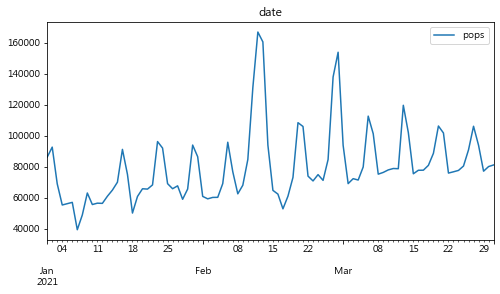

In [74]:
wploteda(0)

### 요일 정렬必  주말이 확연히 높음!

<AxesSubplot:title={'center':'day'}>

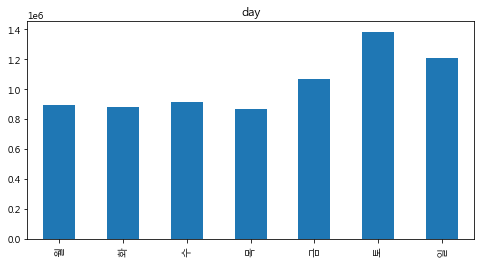

In [75]:
# wploteda(1)

day = wdf(1)
day['orderday']=[5,4,3,1,7,6,2]
day.sort_values(by='orderday').pops.plot(kind='bar',title='day',figsize=(8,4))

<AxesSubplot:title={'center':'home_do'}>

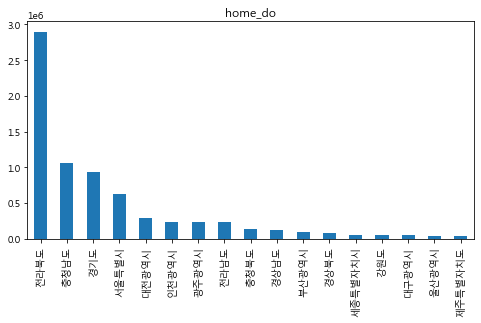

In [76]:
wploteda_v(3)

### 세종시 같은경우 구별 분류가 안되어 있고 도별분류명과 동일하게 설정되어 있어서 문제발생

전라북도 익산시        30619
전라북도 전주시 완산구    27642
충청남도 서천군        24563
Name: home_gu, dtype: int64

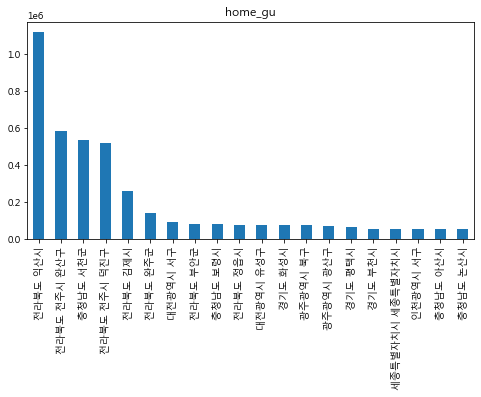

In [77]:
#wploteda_v(2,10)
wploteda_v(4,20)
topgu = list(wdf(2).iloc[:,0].sort_values()[-3:].index)
data.query(f'home_code in {topgu}').home_gu.value_counts()

### 제주는 제주와 서귀포로 나뉘어져 있어서 문제없음

In [258]:
data[data.home_do=='제주특별자치도'].home_gu.value_counts()

제주특별자치도 제주시     6771
제주특별자치도 서귀포시    4704
Name: home_gu, dtype: int64

<AxesSubplot:title={'center':'dst_dong'}>

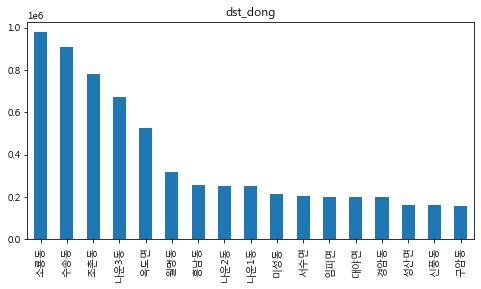

In [259]:
wploteda_v(6)
# wploteda_v(7)

<AxesSubplot:title={'center':'age'}>

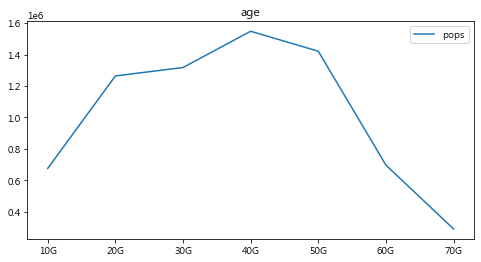

In [260]:
wploteda(8)

<AxesSubplot:title={'center':'sex'}>

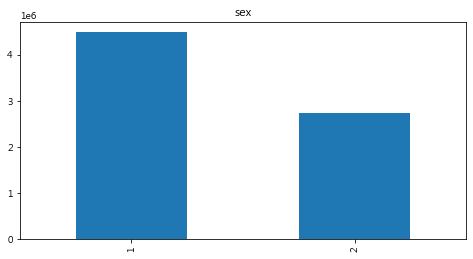

In [261]:
wploteda_v(9)

<AxesSubplot:title={'center':'type'}>

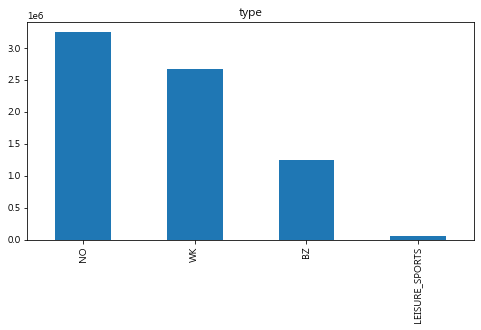

In [262]:
wploteda_v(11)

## SNA

In [264]:
docomer = pd.concat([wdf(3),pd.DataFrame({'pops':0},index=['군산'])])

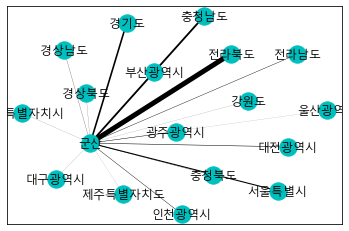

In [266]:
import networkx as nx
nodes = list(docomer.index)
graph = networkx.Graph()
graph.add_nodes_from(nodes)
mat=np.matrix

a=np.matrix(np.zeros([len(docomer)-1,len(docomer)]))
b=docomer.values
mat=np.matrix(np.vstack([a,b.T]))
#from scipy.sparse import random
#mat = random(len(docomer),len(docomer),density=0.3).todense()

for r, rval in enumerate(nodes):
    for c, cval in enumerate(nodes):
        if c<r:
            graph.add_edge(rval,cval, weight1231=mat[r,c])

pos = nx.spring_layout(graph)
edges = graph.edges()

weights = [abs(graph[u][v]['weight1231']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

plt.figure()
nx.draw_networkx_nodes(graph, pos=pos, nodelist=nodes, node_color='c')
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos, font_family='Malgun Gothic')
plt.show()

# 군산to군산 EDA

<AxesSubplot:title={'center':'date'}>

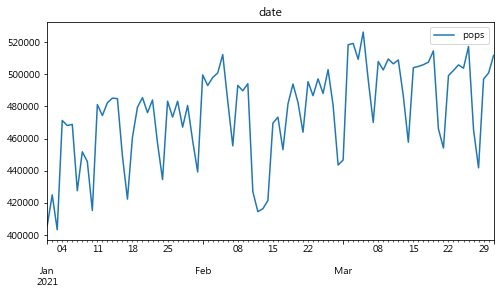

In [121]:
wploteda_gs(0)

<AxesSubplot:title={'center':'day'}>

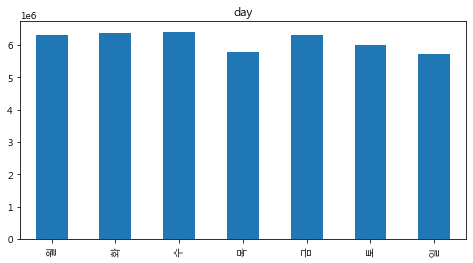

In [122]:
#wploteda_gs(1)
day = wdf_gs(1)
day['orderday']=[5,4,3,1,7,6,2]
day.sort_values(by='orderday').pops.plot(kind='bar',title='day',figsize=(8,4))

<AxesSubplot:title={'center':'dst_dong'}>

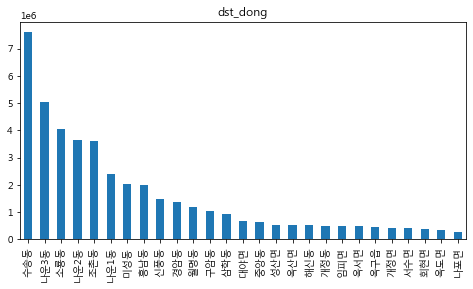

In [123]:
wploteda_v_gs(6)

<AxesSubplot:title={'center':'age'}>

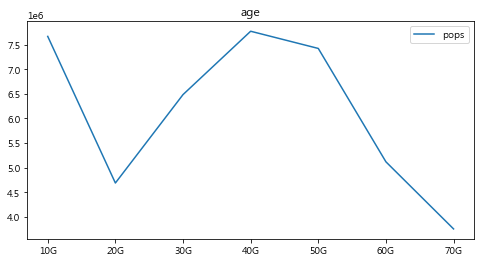

In [125]:
wploteda_gs(8)

<AxesSubplot:title={'center':'sex'}>

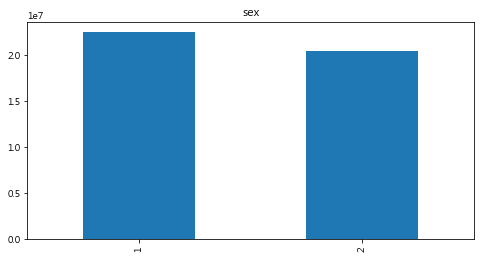

In [126]:
wploteda_v_gs(9)

<AxesSubplot:title={'center':'type'}>

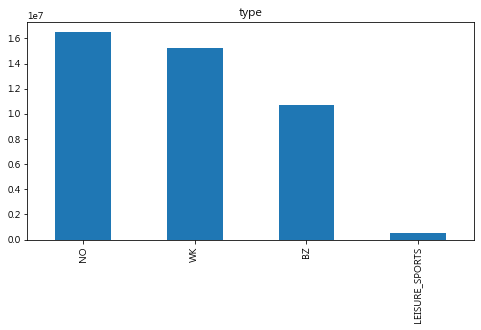

In [130]:
wploteda_v_gs(11)

# 목적지별 EDA

In [153]:
dong_list=list(data.dst_dong.value_counts().index)

In [183]:
#for i,dong in enumerate(dong_list):
#    exec("data_%s=data[data.dst_dong=='%s']" % (dong,dong))

### 군산 제외한 전국에서의 유입 목적지

<AxesSubplot:>

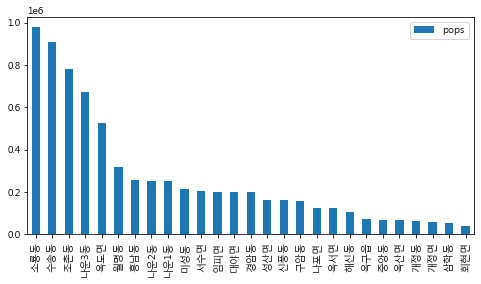

In [190]:
data.pivot_table(index='dst_dong',values='pops',aggfunc='sum').rename_axis(index=None).sort_values('pops',ascending=False)\
.plot(kind='bar',figsize=(8,4))

### 서울에서의 유입 목적지

<AxesSubplot:>

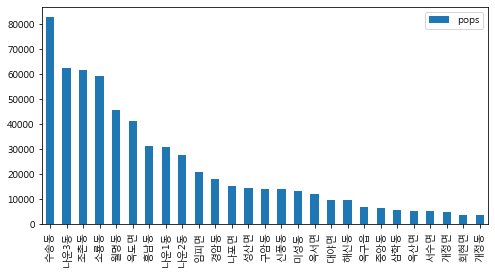

In [192]:
data[data.home_do=='서울특별시'].pivot_table(index='dst_dong',values='pops',aggfunc='sum').rename_axis(index=None).sort_values('pops',ascending=False)\
.plot(kind='bar',figsize=(8,4))

### feature별 동유입수와 비율

In [322]:
def wdong(feature):
    return data.pivot_table(index='dst_dong', columns=feature, values='pops',aggfunc='sum').rename_axis(index=None)
def wdong_ratio(feature):
    wdongr=wdong(feature)
    wdongr.insert(0,"tot",wdongr.sum(1),True)
    return wdongr.iloc[:,1:].div(wd.tot,axis=0)

def wdong_plot(feature):
    wdong(feature).T.plot(figsize=(12,8))
def wdong_ratio_plot(feature):
    wdong_ratio(feature).T.plot(figsize=(12,8))

In [345]:
interested_dong = ['옥도면','월명동','경암동','수송동','나운3동','조촌동','소룡동']

### 연령별 동유입수

<AxesSubplot:xlabel='age'>

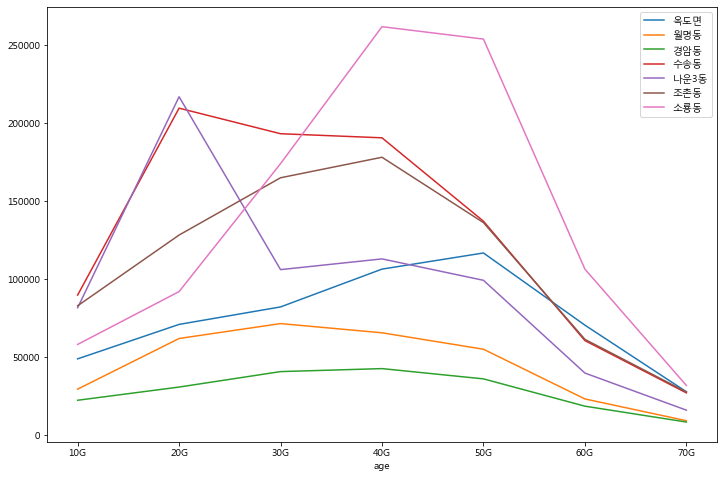

In [346]:
wdong('age').loc[intrested_dong].T.plot(figsize=(12,8))

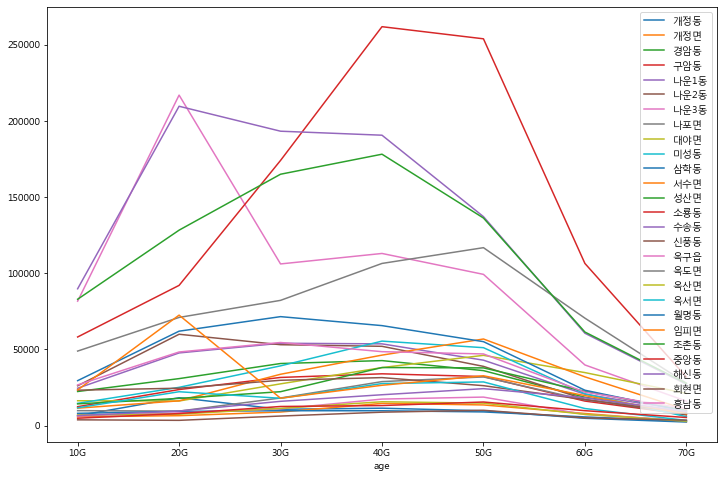

In [323]:
wdong_plot('age')

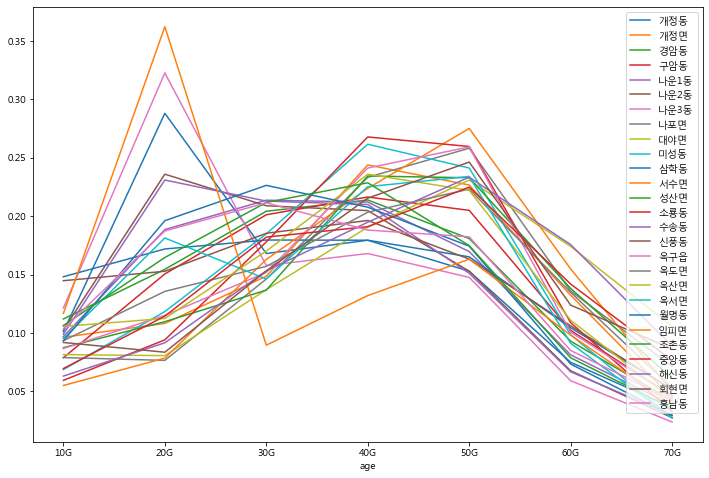

In [318]:
wdong_ratio_plot('age')

<AxesSubplot:>

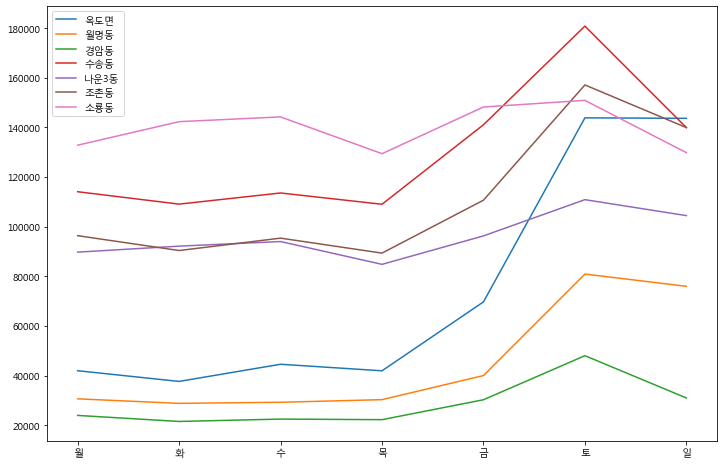

In [348]:
day=wdong('day').T.rename_axis(index=None)[interested_dong]
day['orderday']=[5,4,3,1,7,6,2]
day.sort_values(by='orderday').drop('orderday',axis=1).plot(figsize=(12,8))

<AxesSubplot:xlabel='sex'>

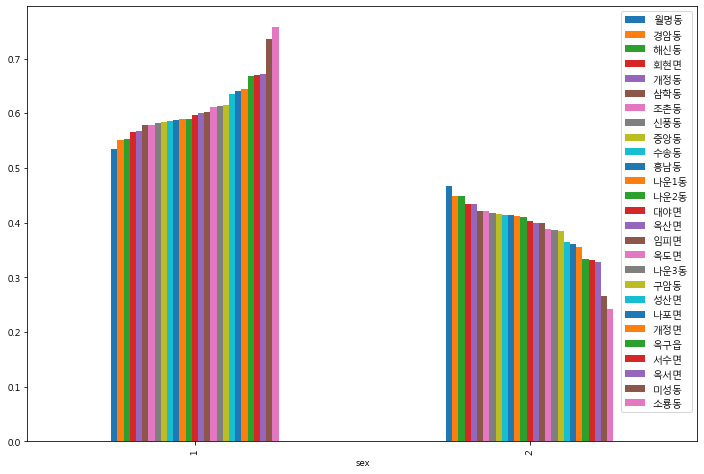

In [374]:
wdong_ratio('sex').sort_values(by=1).T.plot(kind='bar',figsize=(12,8))

<AxesSubplot:title={'center':'성별 주말의 외지인 인구유입'}, xlabel='sex'>

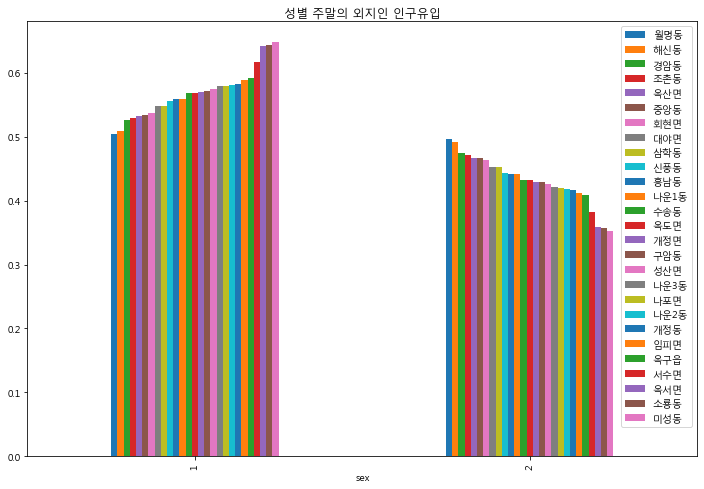

In [375]:
temp = data.query('day in ("토","일")').pivot_table(index='dst_dong', columns='sex', values='pops',aggfunc='sum').rename_axis(index=None)
temp.insert(0,'tot',temp.sum(1))
temp.iloc[:,1:].div(temp.tot,axis=0).sort_values(by=1).T.plot(kind='bar',figsize=(12,8),title='성별 주말의 외지인 인구유입')

### 고군산군도(옥도면) EDA

In [382]:
data_okdo.sex

,date,day,home_code,home_do,home_gu,dst_gu,dst_dong,dst_code,age,sex,pops,type
14570,2021-01-25,월,11110,서울특별시,서울특별시 종로구,군산시,옥도면,4513039000,60G,1,1.632219,NO
14571,2021-01-26,화,11110,서울특별시,서울특별시 종로구,군산시,옥도면,4513039000,60G,1,1.520408,NO
14572,2021-01-26,화,11110,서울특별시,서울특별시 종로구,군산시,옥도면,4513039000,60G,2,3.796955,NO
14573,2021-01-27,수,11110,서울특별시,서울특별시 종로구,군산시,옥도면,4513039000,50G,2,2.185379,NO
14574,2021-01-27,수,11110,서울특별시,서울특별시 종로구,군산시,옥도면,4513039000,60G,1,1.552941,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
1139212,2021-03-07,일,50130,제주특별자치도,제주특별자치도 서귀포시,군산시,옥도면,4513039000,50G,1,2.181009,NO
1139213,2021-03-07,일,50130,제주특별자치도,제주특별자치도 서귀포시,군산시,옥도면,4513039000,40G,2,1.715517,NO
1139214,2021-03-07,일,50130,제주특별자치도,제주특별자치도 서귀포시,군산시,옥도면,4513039000,60G,1,2.497992,NO
1139215,2021-03-07,일,50130,제주특별자치도,제주특별자치도 서귀포시,군산시,옥도면,4513039000,10G,2,2.872093,NO


In [439]:
data_okdo = data[data.dst_dong=='옥도면']
#data_okdo.insert(0,'sexstr',data_okdo['sex'].apply(str))
data_okdo.insert(0,'agesex',data_okdo.age+data_okdo.sex.apply(str))

<AxesSubplot:xlabel='agesex'>

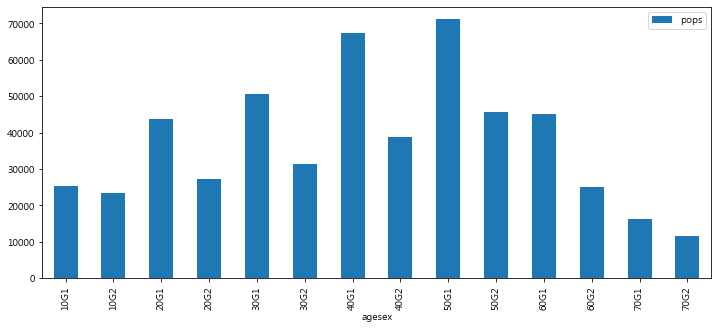

In [448]:
data_okdo.pivot_table(index='agesex',values='pops',aggfunc='sum').plot(kind='bar',figsize=(12,5))

# 연습

## Networkx 연습

### Simplest example modified by me

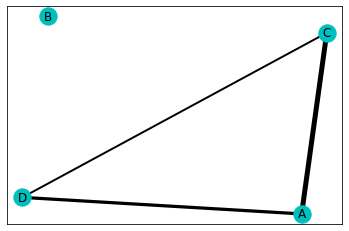

In [610]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random

nodes=['A','B','C','D']
graph = nx.Graph()
graph.add_nodes_from(nodes)
mat = random(4,4,density=0.5).todense()

for row, row_val in enumerate(nodes):
    for col, col_val in enumerate(nodes):
        if col > row: #and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
            graph.add_edge(row_val, col_val, weighT1231=mat[row, col])

# Choose a layout to visualize graph
pos = nx.spring_layout(graph)
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weighT1231']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure()

nx.draw_networkx_nodes(graph, pos=pos, nodelist=nodes, node_color='c')
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

### Original Example

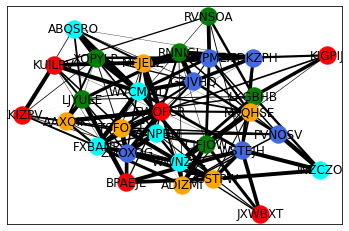

In [407]:
import string, random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random


# Random string generator
def rand_string(size=6, chars=string.ascii_uppercase):
    return ''.join(random.choice(chars) for _ in range(size))


# Set up a nodes and networks randomly
nodes = [rand_string() for _ in range(30)]
networks = [rand_string() for _ in range(5)]
networks_list = networks*6
random.shuffle(networks_list)

# Define what nodes belong to what network and what their color should be
node_network_map = dict(zip(nodes, networks_list))
colors = ['green', 'royalblue', 'red', 'orange', 'cyan']
color_map = dict(zip(networks, colors))

graph = nx.Graph()
graph.add_nodes_from(nodes)
nodes_by_color = {val: [node for node in graph if color_map[node_network_map[node]] == val]
                  for val in colors}

# Take random sparse matrix as adjacency matrix
mat = sparse_random(30, 30, density=0.3).todense()
for row, row_val in enumerate(nodes):
    for col, col_val in enumerate(nodes):
        if col > row and mat[row, col] != 0.0: # Stick to upper half triangle, mat is not symmetric
            graph.add_edge(row_val, col_val, weight=mat[row, col])

# Choose a layout to visualize graph
pos = nx.spring_layout(graph)
edges = graph.edges()

# Get the edge weights and normalize them 
weights = [abs(graph[u][v]['weight']) for u, v in edges]
weights_n = [5*float(i)/max(weights) for i in weights] # Change 5 to control thickness

# First draw the nodes 
plt.figure()
for color, node_names in nodes_by_color.items():
    nx.draw_networkx_nodes(graph, pos=pos, nodelist=node_names, node_color=color)

# Then draw edges with thickness defined by weights_n
nx.draw_networkx_edges(graph, pos=pos, width=weights_n)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

In [411]:
graph['WWNZFE']['MKQHSE']

{'weight': 0.4541394714511223}

### df column값으로(total) 다른 column값들 나누기(비율얻기) np.array로 시도했던것

In [249]:
np.array([1,2,3])[:,None]

array([[1],
       [2],
       [3]])

In [251]:
np.array([1,2,3]).reshape(3,1)

array([[1],
       [2],
       [3]])

In [252]:
np.array([[1,2],[2,4],[6,12]])/np.array([1,2,3]).reshape(3,1)

array([[1., 2.],
       [1., 2.],
       [2., 4.]])

In [ ]:
np.array(wdong('age'))/np.array(pd.DataFrame(wdong('age').T.sum()))[:,None]